### Packages loading

In [1]:
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
from qsee.evolution import environment, mutate, selection, crossover
import qsee.constant
import qsee.ansatz
import qsee.qcompilation
import qsee.state
import qsee.evolution
import qiskit
import numpy as np
%load_ext autoreload
%autoreload 2


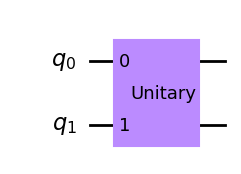

In [7]:
def ising(N,J,h):
    """create Hamiltonian for Ising model
        H = J * sum_{i = 0}^{N-1) Z_i*Z_{i+1} + h*sum_{i=0}^{N-1}X_i
    """
    pauli_op_list = []  
    for j in range(N):
        s = ('I' * (N - j - 1)) + 'X' + ('I' * j)
        pauli_op_list.append((s, h))
    for j in range(N-1):
        s = ('I' * (N - j - 2)) + 'ZZ' + ('I' * j)
        pauli_op_list.append((s, J))  
    h_op = SparsePauliOp.from_list(pauli_op_list)
    return h_op

def hamiltonian(H, t):
    qc = qiskit.QuantumCircuit(2)
    custom_unitary = qiskit.QuantumCircuit(2)
    # Try to replace by your H
    theta = np.pi/2
    u = np.array([[1, 0, 0, 0], 
                [0, np.cos(theta), 0, np.sin(theta)], 
                [0, 0, 1, 0],
                [0, np.sin(theta), 0, -np.cos(theta)]])
    custom_unitary.unitary(u, [0, 1])
    cf_gate = custom_unitary.to_gate(label='Unitary')
    qc.append(cf_gate, [0, 1])
    return qc

hamiltonian().draw('mpl') # => This is V in quantum state preparation
v = hamiltonian()

In [105]:

def compilation_hamiltonian_fitness(qc: qiskit.QuantumCircuit, num_steps=10):
    compiler = qsee.qcompilation.QuantumCompilation(
        u=qc,
        vdagger=v.inverse(),
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
    compiler.fit(num_steps=num_steps, verbose=0)
    return np.average(compiler.loss_values)


def compilation_threshold(fitness_value):
    if fitness_value < 0.1:
        return True
    return False


Main algorithm, includes: init population, selection, crossover, mutate.

In [ ]:
params = {'depth': 4,
          'num_circuit': 16,  # Must mod 8 = 0
          'num_generation': 30,
          'num_qubits': num_qubits,
          'threshold': compilation_threshold,
          'prob_mutate': 0.1}

env = environment.EEnvironment(
    params,
    fitness_func=compilation_fitness,
    selection_func=selection.elitist_selection,
    crossover_func=crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool=qsee.constant.operations,
    file_name='../experiments/evolution/'
)

env.evol()

In [127]:
env.plot(metrics = ['average_fitness', 'best_fitness'])

In [60]:
env2 = environment.EEnvironment('../experiments/evolution/ga_3qubits_4depths_compilation_fitness_2023-10-09.envobj')

Step:   0%|          | 0/10 [10:10:18<?, ?it/s]

Test best candidate again

In [61]:
env.best_candidate.qc.draw('mpl')